## Training fully-convolutional network with synthetic data

In [1]:
import numpy as np
import os
import torch
import time
from torch import nn
from torch.nn import functional
import random

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d

#import uxo_utils

from uxo_cnn_classification import (
    train_net, SurveyParameters, 
    normalize_data, data3dorder,
    accuracy, get_mislabeled,
    confusion_matrix, load_sensor_info
)

In [2]:
# initialization random seed for training and number of epochs:
seeds = [4750, 5293, 9254]
rseed = seeds[0]
nepochs = 60

In [3]:
# sequim group 2021
class_dict = {
    0: "not TOI",
    1: "155mm group",
    2: "105mm group",
    3: "81mm group",
    4: "60mm M49",
    5: "40mm L70",
    6: "clutter0",
    7: "clutter1",
    8: "clutter2",
    9: "clutter3"
}
survpars = SurveyParameters(
    sensor_type = 'ultratema',
    ymax = 4.5,
    y_spacing = 0.3,
    min_standoff = 0.5,
    #noise_file = ''
)
train_case = 'sequimgroup2021'

In [4]:
sensorinfo = load_sensor_info(survpars.sensor_type)
n_class = len(class_dict.keys())
#ntx = len(sensorinfo.transmitters)
#nrx = len(sensorinfo.receivers)//3 # number of receiver cubes
ntx = sensorinfo.ntx
nrx = sensorinfo.nrx
dy = survpars.y_spacing / ntx
nloc = int(survpars.ymax/dy)
ncycles = int(nloc/ntx)

### Load synthetic data, labels and label masks:

In [5]:
data_directory = f"/home/jorge/git/uxo-btg-synthetic/data_{train_case}"

In [6]:
# training dataset is split in different files (mainly to handle memory more efficiently while simulating synthetic data)
nfiles = 2 # here, the last file will be used as test data

In [7]:
#pos = np.load(os.path.sep.join([data_directory, "pos.npy"]))
times = np.load(os.path.sep.join([data_directory, "times.npy"]))
#sensor_table = np.load(os.path.sep.join([data_directory, "sensor_table.npy"]))

labstrain_list = []
for i in range(nfiles-1): # number of files
    labstrain_list.append(np.load(os.path.sep.join([data_directory, f"labels{i}.npy"])))
    
labels_train = np.vstack(labstrain_list)
labels_test = np.load(os.path.sep.join([data_directory, f"labels{nfiles-1}.npy"]))

In [8]:
ntimes = len(times)

In [9]:
labmask_list = []
for i in range(nfiles-1): # number of files
    labmask_list.append(np.load(os.path.sep.join([data_directory, f"labmask{i}.npy"])))
    
labmask_train = np.vstack(labmask_list)

labmask_test = np.load(os.path.sep.join([data_directory, f"labmask{nfiles-1}.npy"]))

In [10]:
dtrain_list = []
for i in range(nfiles-1): # number of files
    dtrain_list.append(np.load(os.path.sep.join([data_directory, f"data{i}.npy"])))
    
data_train = np.vstack(dtrain_list)
del dtrain_list # to free some memory
data_test = np.load(os.path.sep.join([data_directory, f"data{nfiles-1}.npy"]))

In [11]:
data_train.shape

(10000, 144, 15, 25)

## Plot some label masks samples:

In [12]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
if len(class_dict) > 10:
    tab10_list = [mpl.cm.tab10.colors[i] for i in range(10)]
    added_colors = [mpl.colors.to_rgb(c) for c in ["#ebb50a","lightgreen"]][:len(class_dict)-10] # added color to standard tab10
    my_cmap = ListedColormap(tab10_list + added_colors, name="my_cmap")
else:
    my_cmap = ListedColormap([mpl.cm.tab10.colors[i] for i in range(len(class_dict))], name="my_cmap")

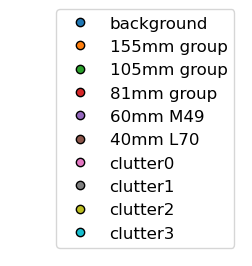

In [13]:
# show labels and colors:
fig, ax = plt.subplots(figsize=(3, n_class*0.2))

marker_size=6
mew = 1.0
custom_lines = [Line2D([0], [0], c="w", marker='o', ms=marker_size, mfc=my_cmap.colors[i], mec="k", lw=1.0, mew=mew) for i in range(len(class_dict))]

ax.axis('off')
ax.legend(custom_lines, ['background'] + list(class_dict.values())[1:], loc="lower right", fontsize=12)

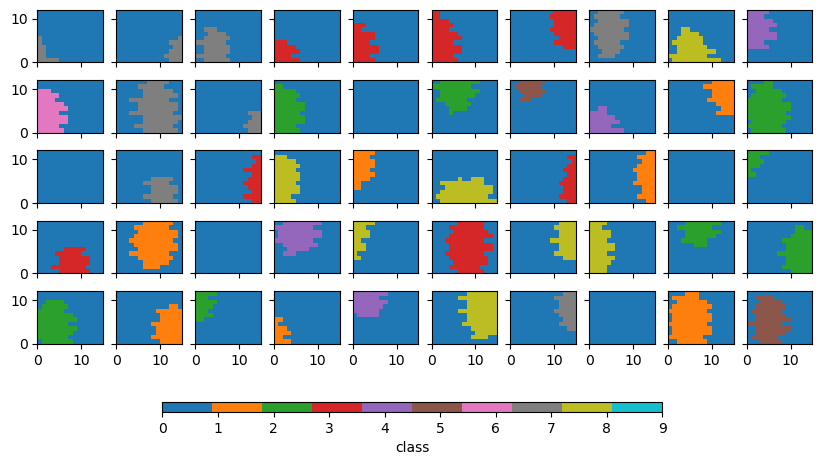

In [14]:
# get masks for random samples
fig, ax = plt.subplots(5,10,figsize=(1.0*10,1.0*5))
#indsamps = np.random.choice(labmask_train.shape[0],size=50)
indsamps = np.arange(50)

ax = ax.ravel()
for i,indi in enumerate(indsamps):
    out = ax[i].pcolormesh(labmask_test[indi,:,:],vmin=0,vmax=n_class-1, cmap=my_cmap)
    if i%10 != 0:
        ax[i].set_yticklabels([])
    if i < 40:
        ax[i].set_xticklabels([])

plt.setp(ax,aspect=1)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.02])
cb = plt.colorbar(out, cbar_ax, orientation="horizontal")
cb.set_label('class')

### Normalize data and convert to torch tensors:

In [15]:
use_scaled = False
use_normalized = True

In [16]:
ntimes = len(times)

if use_scaled or use_normalized:
    time_scaling = (times)
    scaled_data_train = data_train * time_scaling
    scaled_data_test = data_test * time_scaling
    del data_train, data_test

if use_normalized:
    normalized_data_train = normalize_data(scaled_data_train)
    del scaled_data_train
    normalized_data_test = normalize_data(scaled_data_test)
    del scaled_data_test

normalized_data_train = data3dorder(normalized_data_train, survpars.sensor_type)
normalized_data_test = data3dorder(normalized_data_test, survpars.sensor_type)

In [17]:
if use_scaled is True: 
    X_train = torch.from_numpy(np.float32(scaled_data_train))
    X_test = torch.from_numpy(np.float32(scaled_data_test))

elif use_normalized is True: 
    X_train = torch.from_numpy(np.float32(normalized_data_train))
    X_test = torch.from_numpy(np.float32(normalized_data_test))

else: 
    X_train = torch.from_numpy(np.float32(data_train))
    X_test = torch.from_numpy(np.float32(data_test))

C_train = torch.from_numpy(np.float32(labmask_train)).long()
C_test = torch.from_numpy(np.float32(labmask_test)).long()

if use_normalized:
    del normalized_data_train, normalized_data_test

In [18]:
X_train.shape

torch.Size([10000, 12, 12, 15, 25])

### Train neural net:

In [19]:
cnn_pars_dir = os.path.join(os.getcwd(), 'cnn_parameters')

if not os.path.exists(cnn_pars_dir):
    os.mkdir(cnn_pars_dir)

In [20]:
logfile = os.path.join(cnn_pars_dir, f'trainlog_{train_case}_{rseed}')
net = train_net(survpars, class_dict, X_train, C_train, X_test[:1000], C_test[:1000], times, rseed, nepochs, logfile)

gpu detected, training will use it.
Total number of parameters 784662
Total number of training data 10000
Initial loss =  2.1365144
Check:log(10) =  2.302585092994046

Initial accuracy: 0.10761111111111112
Check random    : 0.1
epoch:   0, loss_test: 8.687e-01, accuracy_test: 0.781
epoch:   1, loss_test: 7.548e-01, accuracy_test: 0.847
epoch:   2, loss_test: 7.379e-01, accuracy_test: 0.859
epoch:   3, loss_test: 7.053e-01, accuracy_test: 0.860
epoch:   4, loss_test: 6.903e-01, accuracy_test: 0.878
epoch:   5, loss_test: 6.765e-01, accuracy_test: 0.884
epoch:   6, loss_test: 6.631e-01, accuracy_test: 0.868
epoch:   7, loss_test: 6.591e-01, accuracy_test: 0.903
epoch:   8, loss_test: 6.462e-01, accuracy_test: 0.885
epoch:   9, loss_test: 6.455e-01, accuracy_test: 0.890
epoch:  10, loss_test: 6.583e-01, accuracy_test: 0.894
epoch:  11, loss_test: 6.414e-01, accuracy_test: 0.894
epoch:  12, loss_test: 6.332e-01, accuracy_test: 0.900
epoch:  13, loss_test: 6.370e-01, accuracy_test: 0.891
ep

In [21]:
# save trained parameters:
torch.save(net.state_dict(), os.path.join(cnn_pars_dir, f'net{train_case}_{rseed}.pth'))

In [22]:
# send cnn to cpu for evaluation:
if torch.device != 'cpu':
    net.cpu()

In [23]:
net.eval()

ConvNet(
  (K3d): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 16x12x3x3x3]
      (1): Parameter containing: [torch.FloatTensor of size 16x16x3x3x3]
      (2): Parameter containing: [torch.FloatTensor of size 16x16x3x3x3]
      (3): Parameter containing: [torch.FloatTensor of size 16x16x3x3x3]
  )
  (bnorms3d): ModuleList(
    (0): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (K2d): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 128x400x3x3]
      (1): Parameter containing: [torch.FloatTensor of size 128x128x3x3]
      (2): Parameter conta

In [24]:
X_train.device

device(type='cpu')

In [25]:
nsamples_eval = 100
# training set
x_train_net, probs_train = net(X_train[:nsamples_eval])
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net, probs_test = net(X_test[:nsamples_eval])
_, pred_test = torch.max(probs_test, dim=1)

print(f"training accuracy: {accuracy(probs_train, C_train[:nsamples_eval]):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test[:nsamples_eval]):1.4f}")

#cc = probs_to_classes(probs_train)

training accuracy: 0.9276
test accuracy    : 0.9222


In [26]:
# See where it struggled:
M = confusion_matrix(labmask_train[:100].reshape(100,-1), pred_train[:100].numpy().reshape(100,-1))

In [27]:
M

array([[12287,    58,    36,    58,    61,   114,   663,    97,   149],
       [    1,   917,    24,     0,     0,     0,     0,     0,     0],
       [    0,     0,   490,     0,     0,     0,     0,     0,     0],
       [    1,     0,     0,   477,    17,     2,     0,     0,     1],
       [    1,     0,     0,     1,   301,     0,     5,     0,     0],
       [    5,     0,     0,     0,     0,   606,     4,     0,     1],
       [    1,     0,     0,     0,     0,     0,   551,     0,     0],
       [    3,     0,     0,     0,     0,     0,     0,   556,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,   512]])

### Plot predicted vs true

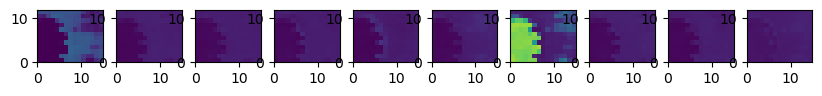

In [44]:
indt = 10
fig,ax = plt.subplots(1,n_class,figsize=(1.0*n_class,2.0))

for i in range(n_class):
    ax[i].pcolormesh(probs_test[indt,i,:,:].detach(),vmin=0,vmax=1,cmap='viridis')
    ax[i].set_aspect(1)

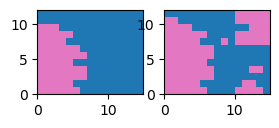

In [45]:
fig,ax = plt.subplots(1,2,figsize=(1.5*2,2.0))

ax[0].pcolormesh(labmask_test[indt,:,:],vmin=0,vmax=n_class-1,cmap=my_cmap)
ax[0].set_aspect(1)
ax[1].pcolormesh(pred_test[indt,:,:],vmin=0,vmax=n_class-1,cmap=my_cmap)
ax[1].set_aspect(1)